In [40]:
print()

In [3]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time

# Dataset

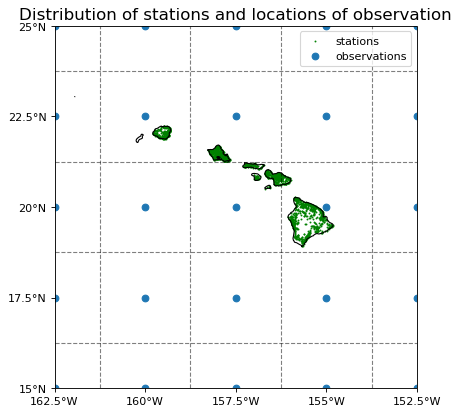

In [4]:
# load location data
base_dir = "../dataset"
df_locations = pd.read_csv(f"{base_dir}/SKNlocations.csv")

lat_hawaii = [15, 17.5, 20, 22.5, 25]
lon_hawaii = [-162.5, -160, -157.5, -155, -152.5]
xx, yy = np.meshgrid(lon_hawaii, lat_hawaii)

plt.figure(figsize=(10, 6), dpi=80)
ax = plt.axes(projection=ccrs.PlateCarree())

xmin, xmax = -162.5, -152.5
ymin, ymax = 15, 25

ax.set_xticks(np.arange(xmin, xmax+1, 2.5))
ax.set_yticks(np.arange(ymin, ymax+1, 2.5))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.grid(linewidth=2, color='black', linestyle='--')

stations = plt.scatter(df_locations["Lon_DD"], df_locations["Lat_DD"], s=0.5, marker='o', color="green", label="stations")
observations = plt.scatter(xx, yy, label="observations")
plt.vlines(x=np.arange(xmin, xmax+1, 2.5) - 1.25, ymin=ymin, ymax=ymax, color="k", linewidth=1, linestyle="--", alpha=0.5)
plt.hlines(y=np.arange(ymin, ymax+1, 2.5) - 1.25 , xmin=xmin, xmax=xmax, color="k", linewidth=1, linestyle="--", alpha=0.5)
plt.title("Distribution of stations and locations of observation", fontsize=(15))
plt.legend()
ax.coastlines(resolution='10m')
print()

In [5]:
# Load the dataset
base_dir = "../dataset"
df_data_original = pd.read_csv(f"{base_dir}/dataset.csv")

# make sure there is no NaN value
assert df_data_original.isnull().values.any() == False
print(f"There are {df_data_original.shape[0]} samples.")
print(
    "Each sample is associated with lat and lon coordinates.\n" + 
    "Use only the closest observation to represent each field, from 16 different NetCDF files.", )

There are 865561 samples.
Each sample is associated with lat and lon coordinates.
Use only the closest observation to represent each field, from 16 different NetCDF files.


# Compare models
## 1. Linear Regression

In [6]:
df_data_clean = df_data_original.drop(labels=["year", "lat", "lon", "month", "skn", "Lon_DD_updated"], axis=1)
df_data_clean.head(3)

,data_in,Lat_DD,Lon_DD,air,air.1,hgt,hgt.1,omega,pottmp,pottmp.1,pr_wtr,shum,shum.1,shum.2,shum.3,shum.4,shum.5,skt,slp
0,3.20,18.916176,-155.674994,295.39603,31.299995,5799.5483,121.48387,0.023998,-26.433594,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849
1,5.95,19.108660,-155.825545,295.39603,31.299995,5799.5483,121.48387,0.023998,-26.433594,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849
2,11.50,19.164740,-155.682280,295.39603,31.299995,5799.5483,121.48387,0.023998,-26.433594,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849


In [7]:
Y = np.array(df_data_clean["data_in"])
X = np.array(df_data_clean.drop(labels=["data_in"], axis=1))
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
linear_regression = LinearRegression()
linear_regression.fit(Xtrain, Ytrain)
yhat = linear_regression.predict(Xtest)
mse = mean_squared_error(yhat, Ytest)
print("MSE: {:.3f}".format(mse))

MSE: 32.344


In [9]:
start = time.time()
ypred = cross_val_predict(LinearRegression(), X, Y, cv=5, n_jobs=-1)
end = time.time()
mse = mean_squared_error(Y, ypred)
print("MSE: {:.3f}".format(mse))
# print(f"{end-start = }")

MSE: 34.935


In [69]:
xgb = XGBRegressor()
xgb.fit(Xtrain, Ytrain)
prediction = xgb.predict(Xtest)
print("MSE: {:.3f}".format(mean_squared_error(Ytest, prediction)))


MSE: 10.592


In [52]:
print("MSE on training set: {:.3f}".format(mean_squared_error(Ytrain, model.predict(Xtrain))))

MSE on training set: 9.997


## 1.1 One model per station

In [53]:
df_data_w_skn = df_data_original.drop(labels=["year", "month", "Lon_DD_updated", "lat", "lon"], axis=1)
df_data_w_skn.head()

,skn,data_in,Lat_DD,Lon_DD,air,air.1,hgt,hgt.1,omega,pottmp,pottmp.1,pr_wtr,shum,shum.1,shum.2,shum.3,shum.4,shum.5,skt,slp
0,1.00,3.200000,18.916176,-155.674994,295.39603,31.299995,5799.5483,121.48387,0.023998,-26.433594,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849
1,2.00,5.950000,19.108660,-155.825545,295.39603,31.299995,5799.5483,121.48387,0.023998,-26.433594,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849
2,2.20,11.500000,19.164740,-155.682280,295.39603,31.299995,5799.5483,121.48387,0.023998,-26.433594,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849
3,2.25,5.515941,19.160603,-155.822488,295.39603,31.299995,5799.5483,121.48387,0.023998,-26.433594,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849
4,2.26,4.310617,19.225323,-155.778876,295.39603,31.299995,5799.5483,121.48387,0.023998,-26.433594,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849


In [54]:
min_data = 50
ytrue = []
ypred = []

num_groups = df_data_w_skn['skn'].unique().shape[0]

for i, (skn, group) in enumerate(df_data_w_skn.groupby("skn")):# iterate the group object
    if group.shape[0] < min_data: continue
    Y = np.array(group["data_in"])
    X = np.array(group.drop(["data_in", "skn"], axis=1))
    
    y_pred = cross_val_predict(LinearRegression(), X, Y, cv=5, n_jobs=-1)
    
    ytrue.extend(Y)
    ypred.extend(y_pred)
    
    # print out the progress
    print(f"{i}/{num_groups}", end="\r")
mse = mean_squared_error(ytrue, ypred)
print()
print("MSE: {:.3f}".format(mse))

1991/1992
MSE: 15.093


# 2. Non-linear Models

## 2.1 Gradient Boosting Trees

In [55]:
# split data into 60/40/40
# use training data to fit the model, validation data to tune the hyperparameters, and test data to report the final performance
df_data_clean = df_data_original.drop(labels=["year", "lat", "lon", "month", "skn", "Lon_DD_updated"], axis=1)
Y = np.array(df_data_clean["data_in"])
X = np.array(df_data_clean.drop(labels=["data_in"], axis=1))
Xtemp, Xtest, Ytemp, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtemp, Ytemp, test_size=0.25)

In [56]:

params = {
    "learning_rate": 1, # [0.05, 1.0]
    "n_estimators": 300,　# [100, 300]
    "subsample": 0.8,
    "max_depth": 4, # [1, 4]
    "loss": "squared_error",
    "verbose": True
}

gradient_boost = GradientBoostingRegressor(**params)
gradient_boost.fit(Xtrain, Ytrain)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1          32.0950           8.9804            8.16m
         2          28.7467           3.3659            8.41m
         3          26.7828           1.8678            8.33m
         4          25.8655           0.9313            8.55m
         5          25.1190           0.7259            8.51m
         6          24.7971           0.2313            8.60m
         7          23.5091           1.1075            8.51m
         8          23.0782           0.5064            8.47m
         9          22.6919           0.2898            8.41m
        10          22.4577           0.3001            8.39m
        20          19.0098           0.1028            8.09m
        30          16.9243           0.1224            7.78m
        40          16.0399           0.0522            7.53m
        50          14.9261           0.1249            7.31m
        60          14.3796           0.0391            6.95m
       

GradientBoostingRegressor(learning_rate=1, max_depth=4, n_estimators=300,
                          subsample=0.8, verbose=True)

In [57]:
yhat = gradient_boost.predict(Xvalid)
mse = mean_squared_error(Yvalid, yhat)
print("MSE on validation set: {:.3f}".format(mse))
print("MSE on test set: {:.3f}".format(mean_squared_error(Ytest, gradient_boost.predict(Xtest))))

MSE on validation set: 10.449
MSE on test set: 10.639


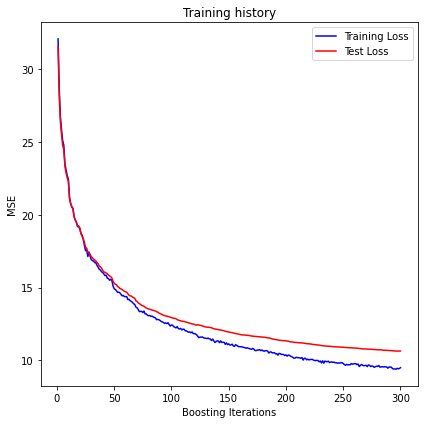

In [58]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gradient_boost.staged_predict(Xtest)):
    test_score[i] = gradient_boost.loss_(Ytest, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Training history")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    gradient_boost.train_score_,
    "b-",
    label="Training Loss",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Loss"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("MSE")
fig.tight_layout()
plt.show()

In [59]:
gradient_boost.feature_importances_

array([0.2175663 , 0.36502247, 0.01055543, 0.01053275, 0.04222203,
       0.00948182, 0.08893126, 0.03678505, 0.00884661, 0.00942858,
       0.01144493, 0.04165658, 0.0325338 , 0.03240872, 0.04974411,
       0.01643588, 0.00872544, 0.00767824])

In [60]:
feature_names = [ # list of tuples. (dataset object, label, attribute string in ds)
    "lat",
    "lon",
    "air2m",
    "air1000_500",
    "hgt500",
    "hgt1000",
    "omega500",
    "pottemp1000-500",
    "pottemp1000-850",
    "pr_wtr",
    "shum-uwnd-700",
    "shum-uwnd-925",
    "shum-vwnd-700",
    "shum-vwnd-950",
    "shum700",
    "shum925",
    "skt",
    "slp"
]

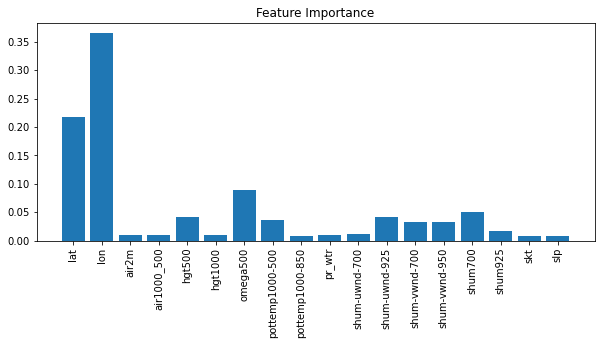

In [61]:
feature_importances = gradient_boost.feature_importances_
ind = np.arange(feature_importances.shape[0])
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Feature Importance")
ax.bar(
    x=ind,
    height=feature_importances
)
ax.set_xticks(ind, feature_names)
ax.tick_params(axis='x', labelrotation=90)
print()

## 2.2 Random Forest

In [62]:
random_forest = RandomForestRegressor()

# split data into 60/40/40
# use training data to fit the model, validation data to tune the hyperparameters, and test data to report the final performance
df_data_clean = df_data_original.drop(labels=["year", "lat", "lon", "month", "skn", "Lon_DD_updated"], axis=1)
Y = np.array(df_data_clean["data_in"])
X = np.array(df_data_clean.drop(labels=["data_in"], axis=1))
Xtemp, Xtest, Ytemp, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtemp, Ytemp, test_size=0.25)

In [63]:
random_forest = RandomForestRegressor(n_jobs=-1, verbose=True)
random_forest.fit(Xtrain, Ytrain)
yhat = random_forest.predict(Xvalid)
mse = mean_squared_error(Yvalid, yhat)
print("MSE: {:.3f}".format(mse))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s


MSE: 7.118


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.5s finished


## 2.2.1 Hyperparameter tuning

In [64]:
params = {
    "n_estimators": 150, # [50, 100]
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "n_jobs": -1,
    "verbose" : True
}


random_forest = RandomForestRegressor(**params)
random_forest.fit(Xtrain, Ytrain)
mse_train = mean_squared_error(Ytrain, random_forest.predict(Xtrain))
mse_valid = mean_squared_error(Yvalid, random_forest.predict(Xvalid))

print("MSE train = {:.3f}\nMSE valid = {:.3f}".format(mse_train, mse_valid))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    5.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.5s


MSE train = 0.970
MSE valid = 7.094


[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    2.2s finished


In [65]:
random_forest.feature_importances_

array([0.22868142, 0.30705782, 0.015042  , 0.01276798, 0.04874886,
       0.01216492, 0.07308309, 0.03399887, 0.01954239, 0.0198063 ,
       0.02041807, 0.04716746, 0.03117996, 0.03955437, 0.04805835,
       0.01698098, 0.01361553, 0.01213162])

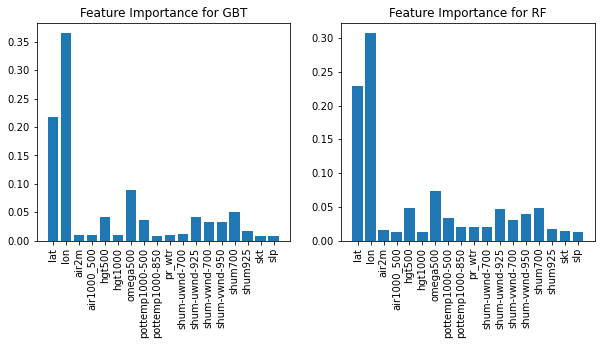

In [66]:
feature_importances_gb = gradient_boost.feature_importances_
feature_importances_rf = random_forest.feature_importances_

ind = np.arange(feature_importances.shape[0])
fig, ax = plt.subplots(1,2, figsize=(10, 4))
ax[0].set_title("Feature Importance for GBT")
ax[0].bar(
    x=ind,
    height=feature_importances_gb
)
ax[0].set_xticks(ind, feature_names)
ax[0].tick_params(axis='x', labelrotation=90)

ax[1].set_title("Feature Importance for RF")
ax[1].bar(
    x=ind,
    height=feature_importances_rf
)
ax[1].set_xticks(ind, feature_names)
ax[1].tick_params(axis='x', labelrotation=90)


print()

In [70]:
## Compare models

Y = np.array(df_data_clean["data_in"])
X = np.array(df_data_clean.drop(labels=["data_in"], axis=1))
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
# simple models
mse_lr = mean_squared_error(Ytest, linear_regression.predict(Xtest))
mse_xgb = mean_squared_error(Ytest, xgb.predict(Xtest))
mse_rf = mean_squared_error(Ytest, random_forest.predict(Xtest))
mse_gbt = mean_squared_error(Ytest, gradient_boost.predict(Xtest))


# multi model for linear regression
min_data = 50
ytrue = []
ypred = []

num_groups = df_data_w_skn['skn'].unique().shape[0]

for i, (skn, group) in enumerate(df_data_w_skn.groupby("skn")):# iterate the group object
    if group.shape[0] < min_data: continue
    Y = np.array(group["data_in"])
    X = np.array(group.drop(["data_in", "skn"], axis=1))
    
    y_pred = cross_val_predict(LinearRegression(), X, Y, cv=5, n_jobs=-1)
    
    ytrue.extend(Y)
    ypred.extend(y_pred)
    
    # print out the progress
    print(f"{i}/{num_groups}", end="\r")
mse_lr_1f1 = mean_squared_error(ytrue, ypred)
print()
# print("MSE: {:.3f}".format(mse))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    2.2s finished


1991/1992


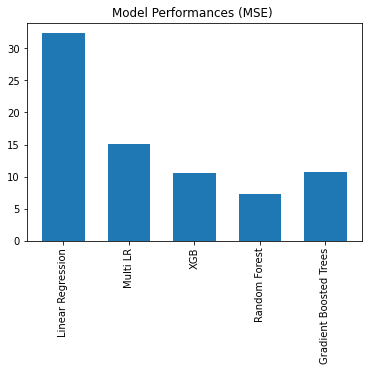

In [76]:
performances = [
    mse_lr,
    mse_lr_1f1,
    mse_xgb, 
    mse_rf,
    mse_gbt
]

ind = np.arange(len(performances))
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Model Performances (MSE) ")
ax.bar(
    x=ind,
    height=performances,
    width=0.65
)
ax.set_xticks(ind, ["Linear Regression", "Multi LR", "XGB", "Random Forest", "Gradient Boosted Trees"])
ax.tick_params(axis='x', labelrotation=90)
print()


In [2]:
print("\n" * 100)

## Try Chrono-split

In [4]:
# convert (year, month) into (months) since 1948 Jan to create continuous index
base_year = 1948
df_data_original["cum_months"] = df_data_original.apply(
    lambda x: 
        int(12 * (x["year"] - base_year) + x["month"])
    ,
    axis=1
)

array([[<AxesSubplot:title={'center':'cum_months'}>]], dtype=object)

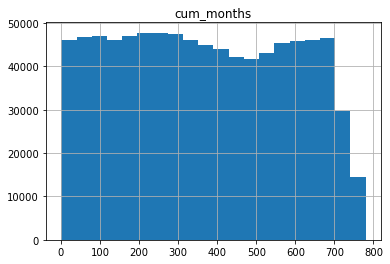

In [7]:
df_data_original.hist("cum_months", bins=20)

array([[<AxesSubplot:title={'center':'cum_months'}>]], dtype=object)

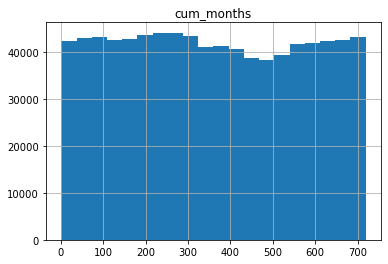

In [15]:
# need to truncate data with cum_months > 700 to deal with the unbalanced dataset
df_data_truncated = df_data_original[df_data_original["cum_months"] < 720]
df_data_truncated.hist(column="cum_months", bins=20)

In [16]:
test_size = 0.2
num_total_data = df_data_truncated.shape[0]
num_test_data = int(num_total_data * test_size)
num_train_data = num_total_data - num_test_data
df_data_sorted_by_months = df_data_truncated.sort_values(by=["cum_months"])
df_train = df_data_sorted_by_months.iloc[:num_train_data]
df_test = df_data_sorted_by_months.iloc[num_train_data:]

In [17]:
df_train

,skn,year,month,data_in,Lat_DD,Lon_DD,Lon_DD_updated,lat,lon,air,...,pr_wtr,shum,shum.1,shum.2,shum.3,shum.4,shum.5,skt,slp,cum_months
0,1.0,1948,1,3.20000,18.916176,-155.674994,204.325006,20.0,205.0,295.39603,...,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.08490,1
263497,675.0,1948,1,5.35000,20.780451,-156.903860,203.096140,20.0,202.5,295.30087,...,28.593227,-0.649968,-33.738140,-2.176032,-8.335284,2.826000,9.923000,23.754120,1013.94574,1
263498,675.1,1948,1,5.43876,20.791839,-156.905250,203.094750,20.0,202.5,295.30087,...,28.593227,-0.649968,-33.738140,-2.176032,-8.335284,2.826000,9.923000,23.754120,1013.94574,1
263499,676.0,1948,1,3.27000,20.761841,-156.904414,203.095586,20.0,202.5,295.30087,...,28.593227,-0.649968,-33.738140,-2.176032,-8.335284,2.826000,9.923000,23.754120,1013.94574,1
263500,677.0,1948,1,4.60000,20.770449,-156.929137,203.070863,20.0,202.5,295.30087,...,28.593227,-0.649968,-33.738140,-2.176032,-8.335284,2.826000,9.923000,23.754120,1013.94574,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442732,396.0,1996,1,4.61000,20.871793,-156.453847,203.546153,20.0,202.5,297.18314,...,32.083237,3.687169,-23.070154,10.525275,15.910310,3.351999,9.944000,25.295092,1014.01720,577
442723,391.2,1996,1,4.97000,20.854770,-156.457841,203.542159,20.0,202.5,297.18314,...,32.083237,3.687169,-23.070154,10.525275,15.910310,3.351999,9.944000,25.295092,1014.01720,577
442721,390.4,1996,1,4.07000,20.834700,-156.513500,203.486500,20.0,202.5,297.18314,...,32.083237,3.687169,-23.070154,10.525275,15.910310,3.351999,9.944000,25.295092,1014.01720,577
442720,390.1,1996,1,6.89000,20.851795,-156.523844,203.476156,20.0,202.5,297.18314,...,32.083237,3.687169,-23.070154,10.525275,15.910310,3.351999,9.944000,25.295092,1014.01720,577


In [18]:
df_test

,skn,year,month,data_in,Lat_DD,Lon_DD,Lon_DD_updated,lat,lon,air,...,pr_wtr,shum,shum.1,shum.2,shum.3,shum.4,shum.5,skt,slp,cum_months
442718,387.2,1996,1,11.364947,20.880126,-156.547177,203.452823,20.0,202.5,297.18314,...,32.083237,3.687169,-23.070154,10.525275,15.910310,3.351999,9.944000,25.295092,1014.0172,577
442717,387.1,1996,1,12.680000,20.883459,-156.535510,203.464490,20.0,202.5,297.18314,...,32.083237,3.687169,-23.070154,10.525275,15.910310,3.351999,9.944000,25.295092,1014.0172,577
442716,387.0,1996,1,6.210000,20.876793,-156.505511,203.494489,20.0,202.5,297.18314,...,32.083237,3.687169,-23.070154,10.525275,15.910310,3.351999,9.944000,25.295092,1014.0172,577
442715,386.6,1996,1,3.520000,20.883200,-156.512300,203.487700,20.0,202.5,297.18314,...,32.083237,3.687169,-23.070154,10.525275,15.910310,3.351999,9.944000,25.295092,1014.0172,577
442714,386.1,1996,1,5.930000,20.883459,-156.507178,203.492822,20.0,202.5,297.18314,...,32.083237,3.687169,-23.070154,10.525275,15.910310,3.351999,9.944000,25.295092,1014.0172,577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255250,355.2,2007,11,2.759843,20.830560,-156.044170,203.955830,20.0,205.0,297.44186,...,32.877666,-17.846325,-67.007430,1.625802,10.166696,3.781000,11.553000,25.377525,1014.5164,719
255251,442.0,2007,11,7.900000,20.885124,-156.243855,203.756145,20.0,205.0,297.44186,...,32.877666,-17.846325,-67.007430,1.625802,10.166696,3.781000,11.553000,25.377525,1014.5164,719
255252,443.0,2007,11,7.230000,20.830128,-156.233301,203.766699,20.0,205.0,297.44186,...,32.877666,-17.846325,-67.007430,1.625802,10.166696,3.781000,11.553000,25.377525,1014.5164,719
255239,344.0,2007,11,7.520000,20.820129,-156.208857,203.791143,20.0,205.0,297.44186,...,32.877666,-17.846325,-67.007430,1.625802,10.166696,3.781000,11.553000,25.377525,1014.5164,719


In [19]:
# Y = np.array(df_data_clean["data_in"])
# X = np.array(df_data_clean.drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])
Ytest = np.array(df_test["data_in"])

Xtrain = np.array(df_train.drop(labels=["data_in", "cum_months", "year", "month", "skn"], axis=1))
Xtest = np.array(df_test.drop(labels=["data_in", "cum_months", "year", "month", "skn"], axis=1))

In [20]:
random_forest = RandomForestRegressor()
random_forest.fit(Xtrain, Ytrain)

RandomForestRegressor()

In [21]:
mse = mean_squared_error(Ytest, random_forest.predict(Xtest))
print("The mean squared error (MSE) on validation set: {:.4f}".format(mse))

The mean squared error (MSE) on validation set: 15.7230


## Get some help from clustering

In [17]:
model = LinearRegression()
encoder = OneHotEncoder(sparse=False)

In [18]:
df_station_label = pd.read_csv(f"{base_dir}/station_cluster.csv")
df_data_clean_w_label = df_data_clean.merge(right=df_station_label, left_on="skn", right_on="SKN")
X = df_data_clean_w_label.drop(labels=["skn", "Lat_DD", "Lon_DD", "Lon_DD_updated", "data_in"], axis=1).to_numpy()
Y = df_data_clean_w_label["data_in"].to_numpy()

In [19]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
model.fit(Xtrain, Ytrain)
yhat = model.predict(Xtest)
mse(Ytest, yhat)

34.11822579192755

## One Hot encode

In [20]:
X = df_data_clean_w_label.drop(labels=["skn", "Lat_DD", "Lon_DD", "Lon_DD_updated", "data_in", "label"], axis=1)
Y = df_data_clean_w_label["data_in"].to_numpy()

In [21]:
label = encoder.fit_transform(df_data_clean_w_label["label"].to_numpy().reshape(-1,1))
X = np.hstack((X, label))

In [22]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
model.fit(Xtrain, Ytrain)
yhat = model.predict(Xtest)
mse(Ytest, yhat)

19.186931714644846

## Gradient Boosting Regressor?

In [23]:
model = GBR()
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
model.fit(Xtrain, Ytrain)
yhat = model.predict(Xtest)
mse(Ytest, yhat)

15.809573718810393